In [1]:
import carla

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from time import sleep
from copy import deepcopy

%matplotlib inline

In [2]:
client = carla.Client("localhost", 2000)
client.set_timeout(10)

In [3]:
map_layers = [
        #carla.MapLayer.Particles,
        #carla.MapLayer.Buildings,
        carla.MapLayer.Ground,
        carla.MapLayer.Walls,
        carla.MapLayer.Decals,
        #carla.MapLayer.Foliage,
        carla.MapLayer.ParkedVehicles,
        #carla.MapLayer.Props,
    ]

def load_map(reload_map: bool, map_name: str):
    if reload_map:

        world = client.load_world(f"{map_name}_Opt",
                                  map_layers=carla.MapLayer.NONE)
        map = world.get_map()
        print("Loaded map: ", str(map))

        for layer in map_layers:
            world.load_map_layer(layer)
        
    return world

In [38]:
map = "Town01"
save_dir = f"maps/{map}/"

stride = 64.0
z = 32.0

world =load_map(reload_map=True, map_name=map)

settings = world.get_settings()
settings.fixed_delta_seconds = 0.05
world.apply_settings(settings)

Loaded map:  Map(name=Carla/Maps/Town01_Opt)


267536

In [39]:
spectator = world.get_spectator()

In [40]:
img_size = 1024

camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_transform = carla.Transform(carla.Location(x=0.0, y=0.0, z=32.0), carla.Rotation(yaw=+00, pitch=-90))
camera_bp.set_attribute("image_size_x",str(img_size))
camera_bp.set_attribute("image_size_y",str(img_size))
camera_bp.set_attribute("fov",str(90))
camera = world.spawn_actor(camera_bp, camera_transform)

In [41]:
def get_image(data):
    global frame
    frame = data

def process_frame(frame, path):
    frame.convert(carla.ColorConverter.CityScapesPalette)
    raw = np.array(frame.raw_data).astype('uint8')
    bgra = np.reshape(raw, (img_size, img_size, 4))
    bgra = Image.fromarray(bgra, 'RGBA')
    img = bgra.convert("L")
    img.save(path)
    return img

In [42]:
camera.listen(lambda data: get_image(data))

In [43]:
def get_mosaic(locs, save_dir):
    imgs = []
    for loc in locs:
        camera.set_location(loc)
        spectator.set_transform(camera.get_transform())
        sleep(0.15)
        img_path = f"{save_dir}/{map}-{int(loc.x)},{int(loc.y)}.jpg"
        img = process_frame(frame, img_path)
        imgs.append(img)
    return imgs

def concat_mosaic(imgs, path='mosaic.jpg'):
    ab = np.concatenate((np.array(imgs[2]), np.array(imgs[3])), axis=1)
    cd = np.concatenate((np.array(imgs[0]), np.array(imgs[1])), axis=1)
    abcd = np.concatenate((ab, cd), axis=0)

    abcd.shape
    mosaic = Image.fromarray(abcd)
    mosaic.save(path)
    return abcd

In [44]:
mopsychos=[]

stride = 64.0
coords = [np.array([0.0, 0.0]), np.array([0.0, stride]), np.array([stride, 0.0]), np.array([stride, stride])] 

offx = 0.0
for offx in [0.0, 128.0, 256.0, 384.0]:
    mosaics=[]
    for offy in [0.0, 128.0, 256.0]:
        locs = [carla.Location(x=coord[0]+offx, y=coord[1]+offy, z=z) for coord in coords]
        imgs = get_mosaic(locs, save_dir)
        mosaics.append(concat_mosaic(imgs, f"{int(offx)}, {int(offy)}.jpg"))

    mopsychos.append(np.concatenate([np.array(im) for im in mosaics], axis=1))

mopsychos.reverse()
psycho = np.concatenate([np.array(im) for im in mopsychos], axis=0)

In [45]:
mo = Image.fromarray(psycho)
mo.save(f"maps/{map}/{map}-{img_size}.jpg")

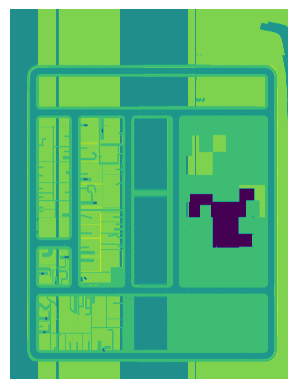

In [46]:
plt.imshow(psycho)
plt.grid(False)
plt.axis('off')
plt.show()

# Preprocess

In [47]:
np.unique(psycho)

array([  0,  21,  42,  83,  85,  90, 106, 118, 137, 138, 153, 154, 157,
       170, 171], dtype=uint8)

In [48]:
bev_classes = {
        0:   0, # Non-Free

        21:     6, # idk  
    }

def remap_seg(bev_img, bev_mapping, n_classes):
    bev_img = bev_img.copy()
    for val, klass in bev_mapping.items():
        bev_img[bev_img == val] = klass
   # bev_img[bev_img > n_classes] = 0
    return bev_img

map = remap_seg(psycho, bev_classes, n_classes=5)

In [49]:
np.unique(map, return_counts=True)

(array([  0,   6,  42,  83,  85,  90, 106, 118, 137, 138, 153, 154, 157,
        170, 171], dtype=uint8),
 array([ 1011149,     2759,    20197,     9558, 10850660,  6080914,
          169222, 15343614,     2451, 16464958,     2549,     1193,
          324486,    32629,    15309]))

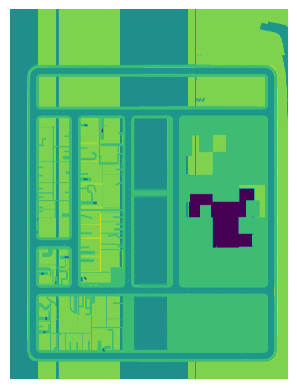

In [50]:
plt.imshow(map)
plt.grid(False)
plt.axis('off')
plt.show()

In [ ]:
bev_class2color = {
    0:  (150, 150, 150), # Non-Free
    1:  (255, 255, 255), # Free space
    2:  (220, 220, 220),  # Sidewalk
    3:  (  0,   7, 165),      # Vehicles
    4:  (200,  35,   0),      # Pedestrians
    5:  (255, 209, 103),    # RoadLines
}